# New York Times Annotated Corpus keyword labeling with pre-trained word embeddings

In this notebook, we'll use pre-trained [GloVe word embeddings](http://nlp.stanford.edu/projects/glove/) for keyword labeling using Keras (version $\ge$ 2 is required). This notebook is largely based on the blog post [Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) by François Chollet.

**Note that using a GPU with this notebook is highly recommended.**

First, the needed imports. Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.

In [1]:
%matplotlib inline

from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM, CuDNNLSTM
from keras.utils import to_categorical

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn import metrics

import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.2 backend: tensorflow


If we are using TensorFlow as the backend, we can use TensorBoard to visualize our progress during training.

In [2]:
if K.backend() == "tensorflow":
    import tensorflow as tf
    print('TensorFlow version:', tf.__version__)
    from keras.callbacks import TensorBoard
    import os, datetime
    logdir = os.path.join(os.getcwd(), "logs",
                     "ted-"+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    print('TensorBoard log directory:', logdir)
    os.makedirs(logdir)
    callbacks = [TensorBoard(log_dir=logdir)]
else:
    callbacks =  None

TensorFlow version: 1.10.0
TensorBoard log directory: /home/cloud-user/machine-learning-scripts/notebooks/logs/ted-2018-10-12_13-19-38


## GloVe word embeddings

Let's begin by loading a datafile containing pre-trained word embeddings.  The datafile contains 100-dimensional embeddings for 400,000 English words.  

In [3]:
#!wget --content-disposition -nc https://kannu.csc.fi/s/rrCNCRdJf9LZSCE/download
GLOVE_DIR = "/home/cloud-user/machine-learning-scripts/notebooks"

#GLOVE_DIR = "/home/cloud-user/glove.6B"

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = len(coefs)
print('Found %d word vectors of dimensionality %d.' % (len(embeddings_index), embedding_dim))

print('Examples of embeddings:')
for w in ['some', 'random', 'words']:
    print(w, embeddings_index[w])

Indexing word vectors.
Found 400000 word vectors of dimensionality 100.
Examples of embeddings:
some [-1.4452e-01  5.6023e-01  2.0540e-01 -2.6664e-01 -2.5669e-01  5.2548e-01
 -4.5982e-01  2.1998e-01 -1.3937e-02 -2.4225e-01  1.8083e-01  7.1322e-02
  3.8370e-01 -3.6641e-01  5.1304e-01 -3.7246e-01 -1.9897e-01 -5.5156e-02
  2.0737e-02  7.0062e-01  8.1707e-01 -9.9955e-02  1.6988e-01 -2.5001e-01
 -2.6900e-01 -6.9777e-01 -3.5842e-02 -5.0822e-01 -5.9415e-03 -3.2951e-01
  1.8912e-01  8.4527e-02 -4.3161e-01 -2.8211e-02 -1.9869e-01  4.7913e-01
  6.4726e-02  2.9788e-01 -2.7285e-01  1.2602e-01 -9.6007e-01 -4.5345e-01
  1.8871e-01 -4.1984e-01  4.6052e-02 -2.4216e-01  4.7940e-01 -2.2272e-01
 -5.5945e-02 -4.7897e-01  9.0283e-02 -5.9132e-02 -2.4845e-01  1.0303e+00
 -4.3041e-01 -2.4090e+00  1.7499e-01 -6.1541e-01  1.8243e+00  7.7120e-01
  2.4063e-01  1.6522e+00 -3.9428e-02  5.1181e-01  7.2804e-01 -3.0182e-01
  8.1372e-01  3.2864e-01  6.7350e-01 -3.9717e-01 -4.5192e-01 -3.8743e-02
 -1.1955e-01 -2.1259e-0

## New York Times Annotated Corpus

Next we'll load the [New York Times Annotated Corpus](https://catalog.ldc.upenn.edu/ldc2008t19).  The data is originally in stored in article-wise XML files, but we load a portion of the data from a preprocessed HDF5 file instead. 

The preprocessed dataset contains articles of year 1987. Each article is annotated with a set of tags.

In [4]:
TEXT_DATA_DIR = "/home/cloud-user/nytac"

store = pd.HDFStore(TEXT_DATA_DIR+'/1987.h5')
df = store['df']
labels_all_sorted = store['labels_all_sorted']
store.close()

print(len(df), 'articles')
df.sample(10)

106104 articles


,doc-id,title,descriptor,person,org,location,object,types_of_material,taxonomic_classifier,general_descriptor,lead_paragraph,full_text,descriptor_indices
20276,20276,DYNASCAN CORP reports earnings for Qtr to Dec 31,[COMPANY REPORTS],[],[],[],[],[Statistics],[Top/News/Business],"[Company Reports, Corporations]",LEAD: *3*** COMPANY REPORTS ** *3*DYNASCAN COR...,*3*** COMPANY REPORTS ** *3*DYNASCAN CORP (OTC...,[0]
85483,85487,SYSCO CORP reports earnings for Qtr to Sept 26,[COMPANY REPORTS],[],[],[],[],[Statistics],[Top/News/Business],"[Company Reports, Corporations]",LEAD: *3*** COMPANY REPORTS ** *3*SYSCO CORP (...,*3*** COMPANY REPORTS ** *3*SYSCO CORP (NYSE) ...,[0]
43222,43222,NORTHEAST SAVINGS FEDERAL ASSOCIATION reports ...,[COMPANY REPORTS],[],[],[],[],[Statistics],[Top/News/Business],"[Company Reports, Corporations]",LEAD: *3*** COMPANY REPORTS ** *3*NORTHEAST SA...,*3*** COMPANY REPORTS ** *3*NORTHEAST SAVINGS ...,[0]
930,930,HELL'S UPPER STORY,[BOOK REVIEWS],"[FRANKLIN, BEN A, DEKOK, DAVID, JACOBS, RENEE]",[],[],"[UNSEEN DANGER (BOOK), SLOW BURN (BOOK)]",[review],"[Top/Features/Books/Book Reviews, Top/Features...",[Books and Literature],"LEAD: UNSEEN DANGER A Tragedy of People, Gov...","UNSEEN DANGER A Tragedy of People, Government...",[18]
85447,85451,Producer's New Script: A Media General Deal,"[MERGERS, ACQUISITIONS AND DIVESTITURES]","[CUFF, DANIEL F, SUGARMAN, BERT]",[MEDIA GENERAL INC],[],[BUSINESS PEOPLE (TIMES COLUMN)],[],[Top/News/Business],"[Mergers, Acquisitions and Divestitures, Finan...",LEAD: Burt Sugarman is a film producer who has...,Burt Sugarman is a film producer who has becom...,[3]
92616,92620,ELRON ELECTRONIC INDUSRIES INC reports earning...,[COMPANY REPORTS],[],[],[],[],[Statistics],[Top/News/Business],"[Company Reports, Corporations]",LEAD: *3*** COMPANY REPORTS ** *3*ELRON ELECTR...,*3*** COMPANY REPORTS ** *3*ELRON ELECTRONIC I...,[0]
56116,56118,"The Book Clubs, Chapter 2","[BOOKS AND LITERATURE, INDUSTRY PROFILES]","[VON PUTTKAMER, PETER, GLABERSON, WILLIAM]","[BOOK-OF-THE-MONTH CLUB, LITERARY GUILD, BERTE...",[],[],[],"[Top/News/Business, Top/News/Business/Media an...","[Industry Profiles, Books and Literature]",LEAD: THE first suggestion of a sultry New Yor...,THE first suggestion of a sultry New York summ...,"[52, 420]"
103436,103440,Ford Ordered to Pay Damages,"[AUTOMOBILES, DECISIONS AND VERDICTS, SEAT BEL...",[],[FORD MOTOR CO],[BALTIMORE (MD)],[],[],"[Top/News/U.S., Top/News/U.S./U.S. States, Ter...","[Decisions and Verdicts, Seat Belts, Seat Belt...",LEAD: A Federal jury has ordered the Ford Moto...,A Federal jury has ordered the Ford Motor Comp...,"[73, 74, 1019, 19, 974]"
7240,7240,Appeal Is Made for 10 Kidnapped in Somalia,"[REFUGEES AND EXPATRIATES, DOCTORS, KIDNAPPING...",[],[DOCTORS WITHOUT BORDERS],"[SOMALIA, FRANCE, ETHIOPIA]",[],[],"[Top/News, Top/News/World/Countries and Territ...","[Doctors, Kidnapping, Immigration and Refugees...",LEAD: The Foreign Ministry said today that it ...,The Foreign Ministry said today that it had as...,"[239, 205, 262, 239, 68]"
101005,101009,VICORP RESTAURANTS INC reports earnings for Qt...,[COMPANY REPORTS],[],[],[],[],[Statistics],[Top/News/Business],"[Company Reports, Corporations]",LEAD: *3*** COMPANY REPORTS ** *3*VICORP RESTA...,*3*** COMPANY REPORTS ** *3*VICORP RESTAURANTS...,[0]


### Textual data

There are two potential columns to be used as the input text source: `full_text` and `lead_paragraph`. The former is the full text of the article, whereas the latter is a shorter abstract of the contents of the article. 

Let's inspect the distributions of the lengths of these columns: 

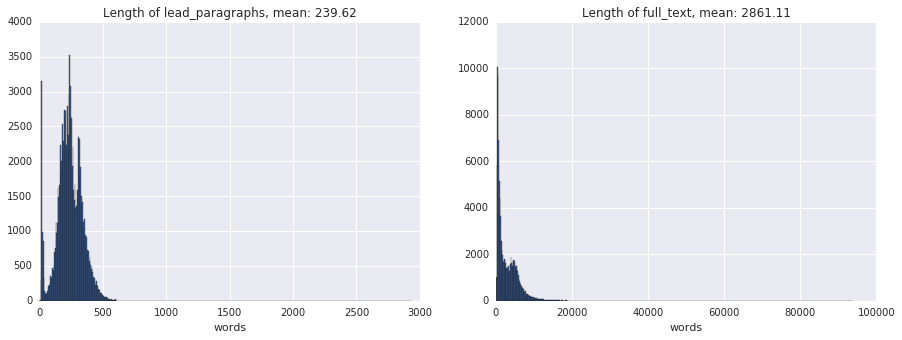

In [5]:
len_lead, len_full = np.empty(len(df)), np.empty(len(df))
for i, row in df.iterrows():
   len_lead[i]=len(row['lead_paragraph'])
   len_full[i]=len(row['full_text'])

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Length of lead_paragraphs, mean: %.2f' % np.mean(len_lead))
plt.xlabel('words')
plt.hist(len_lead, 'auto')
plt.subplot(122)
plt.title('Length of full_text, mean: %.2f' % np.mean(len_full))
plt.xlabel('words')
plt.hist(len_full, 'auto');

Now we decide to use either the `transcipt` or the `description` column:

In [6]:
texttype = "full_text"
#texttype = "lead_paragraph"

### Keywords

We use the `NLABELS` most frequent descriptor tags as keyword labels we wish to predict:

Total of 3613 descriptor tags. Showing 100 most common tags:
0 COMPANY REPORTS 18507 0.1744
1 UNITED STATES INTERNATIONAL RELATIONS 3581 0.0337
2 REVIEWS 3580 0.0337
3 MERGERS, ACQUISITIONS AND DIVESTITURES 2974 0.0280
4 STOCKS AND BONDS 2881 0.0272
5 MUSIC 2854 0.0269
6 WEDDINGS AND ENGAGEMENTS 2700 0.0254
7 POLITICS AND GOVERNMENT 2534 0.0239
8 BASEBALL 2482 0.0234
9 FINANCES 2308 0.0218
10 DEATHS 2219 0.0209
11 ARMAMENT, DEFENSE AND MILITARY FORCES 2178 0.0205
12 FOOTBALL 2065 0.0195
13 LAW AND LEGISLATION 1953 0.0184
14 UNITED STATES ARMAMENT AND DEFENSE 1947 0.0183
15 APPOINTMENTS AND EXECUTIVE CHANGES 1906 0.0180
16 CONCERTS AND RECITALS 1797 0.0169
17 TELEVISION 1765 0.0166
18 BOOK REVIEWS 1754 0.0165
19 ACCIDENTS AND SAFETY 1678 0.0158
20 BASKETBALL 1600 0.0151
21 HOUSING 1526 0.0144
22 LABOR 1513 0.0143
23 CIVIL WAR AND GUERRILLA WARFARE 1477 0.0139
24 EDITORIALS 1444 0.0136
25 ETHICS 1356 0.0128
26 ECONOMIC CONDITIONS AND TRENDS 1353 0.0128
27 INTERNATIONAL TRADE AND WORLD MA

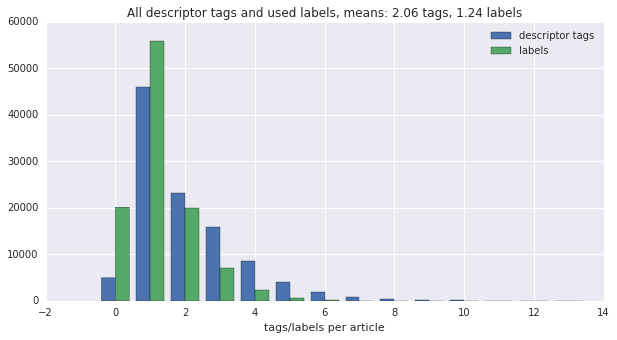

In [7]:
NLABELS=100

def indices_to_labels(x):
    labels = np.zeros(NLABELS)
    for i in x:
        if i < NLABELS:
            labels[i] = 1
    return labels

df['labels'] = df['descriptor_indices'].apply(indices_to_labels)

ntags = dict()
l, ll = np.zeros(len(df)), np.zeros(len(df))

for i, tl in df['descriptor'].iteritems():    
    for t in tl:
        if t == "Terms not available":
            continue
        l[i] += 1
        if t in ntags:
            ntags[t] += 1
        else:
            ntags[t] = 1

for i, labv in df['labels'].iteritems():    
    ll[i] = np.sum(labv)
            
nrows = len(df)
print('Total of', len(labels_all_sorted), 'descriptor tags. Showing', NLABELS, 'most common tags:')
for i, t in enumerate(labels_all_sorted[:NLABELS]):
    print(i, t, ntags[t], "%.4f" % (ntags[t]/nrows))

plt.figure(figsize=(10,5))
plt.title('All descriptor tags and used labels, means: %.2f tags, %.2f labels' % (np.mean(l), np.mean(ll)))
plt.xlabel('tags/labels per article')
plt.hist([l,ll],np.arange(0,15), align='left', label=['descriptor tags', 'labels'])
plt.legend(loc='best');

### Produce input and label tensors

We vectorize the text samples and labels into a 2D integer tensors. `MAX_NUM_WORDS` is the number of different words to use as tokens, selected based on word frequency. `MAX_SEQUENCE_LENGTH` is the fixed sequence length obtained by truncating or padding the original sequences. 

In [8]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000 

tokenizer = text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts([x for x in df[texttype]])
sequences = tokenizer.texts_to_sequences([x for x in df[texttype]])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.asarray([x for x in df['labels']])

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Found 333855 unique tokens.
Shape of data tensor: (106104, 1000)
Shape of labels tensor: (106104, 100)


Next, we split the data into a training, validation, and test sets.

In [9]:
VALIDATION_SET, TEST_SET = 10000, 10000

x_train, x_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=TEST_SET,
                                                    shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=VALIDATION_SET,
                                                  shuffle=False)

print('Shape of training data tensor:', x_train.shape)
print('Shape of training label tensor:', y_train.shape)
print('Shape of validation data tensor:', x_val.shape)
print('Shape of validation label tensor:', y_val.shape)
print('Shape of test data tensor:', x_test.shape)
print('Shape of test label tensor:', y_test.shape)

Shape of training data tensor: (86104, 1000)
Shape of training label tensor: (86104, 100)
Shape of validation data tensor: (10000, 1000)
Shape of validation label tensor: (10000, 100)
Shape of test data tensor: (10000, 1000)
Shape of test label tensor: (10000, 100)


We prepare the embedding matrix by retrieving the corresponding word embedding for each token in our vocabulary:

In [10]:
print('Preparing embedding matrix.')

num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print('Shape of embedding matrix:', embedding_matrix.shape)

Preparing embedding matrix.
Shape of embedding matrix: (10000, 100)


## 1-D CNN

### Initialization


In [11]:
print('Build model...')
model = Sequential()

model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
#model.add(Dropout(0.2))

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(NLABELS, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop')

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0     

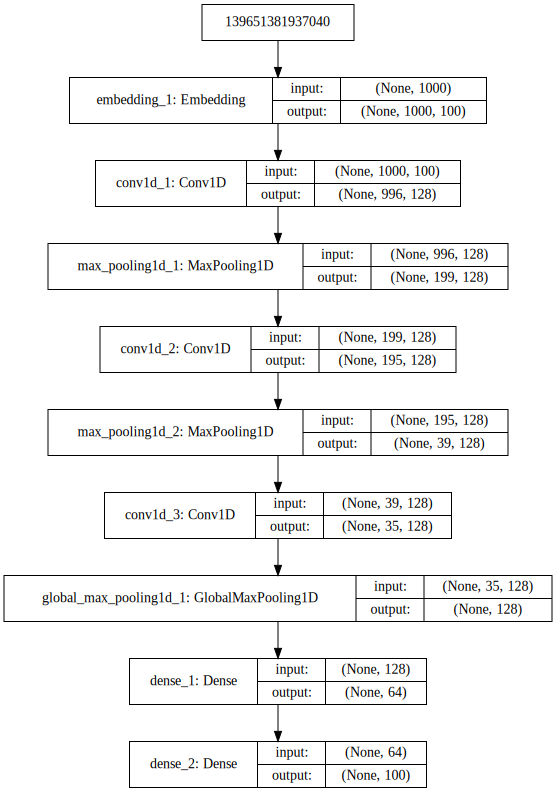

In [12]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Learning

In [13]:
%%time
epochs = 5
batch_size=64

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    verbose=2, callbacks=callbacks)

Train on 86104 samples, validate on 10000 samples
Epoch 1/5
 - 17s - loss: 0.0462 - val_loss: 0.0340
Epoch 2/5
 - 14s - loss: 0.0286 - val_loss: 0.0288
Epoch 3/5
 - 14s - loss: 0.0249 - val_loss: 0.0256
Epoch 4/5
 - 14s - loss: 0.0231 - val_loss: 0.0250
Epoch 5/5
 - 14s - loss: 0.0219 - val_loss: 0.0252
CPU times: user 1min 17s, sys: 12.5 s, total: 1min 30s
Wall time: 1min 13s


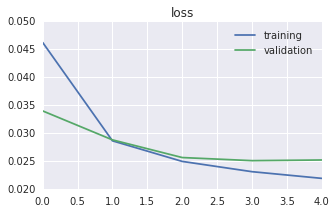

In [14]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best');

### Inference

To further analyze the results, we can produce the actual predictions for the test data.

In [15]:
predictions = model.predict(x_test)

The selected threshold controls the number of label predictions we'll make:

In [16]:
threshold = 0.25

avg_n_gt, avg_n_pred = 0, 0
for t in range(len(y_test)):
    avg_n_gt += len(np.where(y_test[t]>0.5)[0])
    avg_n_pred += len(np.where(predictions[t]>threshold)[0])
avg_n_gt /= len(y_test)
avg_n_pred /= len(y_test)
print('Average number of ground-truth labels per talk: %.2f' % avg_n_gt)
print('Average number of predicted labels per talk: %.2f' % avg_n_pred)

Average number of ground-truth labels per talk: 1.23
Average number of predicted labels per talk: 1.19


Let's look at the correct and predicted labels for some talks in the validation set.

In [20]:
nb_articles_to_show = 20

for t in range(nb_articles_to_show):
    print(t,':')
    print('    correct: ', end='')
    for idx in np.where(y_test[t]>0.5)[0].tolist():
        sys.stdout.write('['+labels_all_sorted[idx]+'] ')
    print()
    print('  predicted: ', end='')
    for idx in np.where(predictions[t]>threshold)[0].tolist():
        sys.stdout.write('['+labels_all_sorted[idx]+'] ')
    print()

0 :
    correct: [TELEVISION] 
  predicted: [FOOTBALL] 
1 :
    correct: [COMPANY REPORTS] 
  predicted: [COMPANY REPORTS] 
2 :
    correct: 
  predicted: [ACCIDENTS AND SAFETY] 
3 :
    correct: [COMPANY REPORTS] 
  predicted: [COMPANY REPORTS] 
4 :
    correct: [FOOD] 
  predicted: 
5 :
    correct: [COMPANY REPORTS] 
  predicted: [COMPANY REPORTS] 
6 :
    correct: [ATHLETICS AND SPORTS] 
  predicted: [ATHLETICS AND SPORTS] 
7 :
    correct: 
  predicted: [BASKETBALL] 
8 :
    correct: [COMPANY REPORTS] 
  predicted: [COMPANY REPORTS] 
9 :
    correct: [EDITORIALS] 
  predicted: 
10 :
    correct: [WEDDINGS AND ENGAGEMENTS] 
  predicted: [WEDDINGS AND ENGAGEMENTS] 
11 :
    correct: [STRIKES] [WAGES AND SALARIES] 
  predicted: [LABOR] [CONTRACTS] [STRIKES] [WAGES AND SALARIES] 
12 :
    correct: 
  predicted: [ACCIDENTS AND SAFETY] [AIRLINES AND AIRPLANES] 
13 :
    correct: [COMPANY REPORTS] 
  predicted: [COMPANY REPORTS] 
14 :
    correct: [UNITED STATES INTERNATIONAL RELATIONS] 

Scikit-learn has some applicable performance [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) we can try: 

Precision: 0.659 (threshold: 0.25)
Recall: 0.639 (threshold: 0.25)
F1 score: 0.649 (threshold: 0.25)
Average precision: 0.704
Coverage: 4.054
LRAP: 0.843


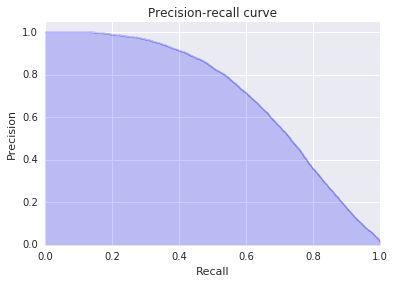

In [19]:
print('Precision: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.precision_score(y_test.flatten(), predictions.flatten()>threshold), threshold))
print('Recall: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.recall_score(y_test.flatten(), predictions.flatten()>threshold), threshold))
print('F1 score: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.f1_score(y_test.flatten(), predictions.flatten()>threshold), threshold))

average_precision = metrics.average_precision_score(y_test.flatten(), predictions.flatten())
print('Average precision: {0:.3f}'.format(average_precision))
print('Coverage: {0:.3f}'
      .format(metrics.coverage_error(y_test, predictions)))
print('LRAP: {0:.3f}'
      .format(metrics.label_ranking_average_precision_score(y_test, predictions)))

precision, recall, _ = metrics.precision_recall_curve(y_test.flatten(), predictions.flatten())
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve');

## LSTM

### Initialization

In [ ]:
print('Build model...')
model = Sequential()

model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
#model.add(Dropout(0.2))

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(CuDNNLSTM(256))

model.add(Dense(128, activation='relu'))
model.add(Dense(NLABELS, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop')

print(model.summary())

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Learning

In [ ]:
%%time
epochs = 20
batch_size=64

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    verbose=2, callbacks=callbacks)

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best');

### Inference

In [ ]:
predictions = model.predict(x_test)

In [ ]:
threshold = 0.5

avg_n_gt, avg_n_pred = 0, 0
for t in range(len(y_test)):
    avg_n_gt += len(np.where(y_test[t]>0.5)[0])
    avg_n_pred += len(np.where(predictions[t]>threshold)[0])
avg_n_gt /= len(y_test)
avg_n_pred /= len(y_test)
print('Average number of ground-truth labels per talk: %.2f' % avg_n_gt)
print('Average number of predicted labels per talk: %.2f' % avg_n_pred)

In [ ]:
nb_articles_to_show = 20

for t in range(nb_articles_to_show):
    print(t,':')
    print('    correct: ', end='')
    for idx in np.where(y_test[t]>0.5)[0].tolist():
        sys.stdout.write('['+labels_all_sorted[idx]+'] ')
    print()
    print('  predicted: ', end='')
    for idx in np.where(predictions[t]>threshold)[0].tolist():
        sys.stdout.write('['+labels_all_sorted[idx]+'] ')
    print()

In [ ]:
print('Precision: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.precision_score(y_test.flatten(), predictions.flatten()>threshold), threshold))
print('Recall: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.recall_score(y_test.flatten(), predictions.flatten()>threshold), threshold))
print('F1 score: {0:.3f} (threshold: {1:.2f})'
      .format(metrics.f1_score(y_test.flatten(), predictions.flatten()>threshold), threshold))

average_precision = metrics.average_precision_score(y_test.flatten(), predictions.flatten())
print('Average precision: {0:.3f}'.format(average_precision))
print('Coverage: {0:.3f}'
      .format(metrics.coverage_error(y_test, predictions)))
print('LRAP: {0:.3f}'
      .format(metrics.label_ranking_average_precision_score(y_test, predictions)))

precision, recall, _ = metrics.precision_recall_curve(y_test.flatten(), predictions.flatten())
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve');